In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpy as np
import pandas as pd
import seaborn as sns
from jax import random
from numpyro import diagnostics, infer
from sklearn import datasets
from sklearn import linear_model

np.random.seed(12345)
rng_key = random.PRNGKey(0)

numpyro.set_host_device_count(4)

# Data

In [2]:
x, y = datasets.load_diabetes(return_X_y=True)
x = jnp.array(x)
y = jnp.array(y)

x.shape, y.shape

((442, 10), (442,))

# Model

In [3]:
def spike_and_slab(x, y=None):
    batch, x_dim = x.shape
    s = numpyro.sample("s", dist.HalfCauchy(10.0))
    with numpyro.plate("x_dim", x_dim, dim=-1):
        pi = numpyro.sample("pi", dist.Beta(0.5, 0.5))
        xi = numpyro.sample("xi", dist.Bernoulli(pi))
        w = numpyro.sample("w", dist.Normal(0, s))

        beta = numpyro.deterministic("beta", w * xi)

    bias = numpyro.sample("bias", dist.Normal(150, 20))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    mu = jnp.matmul(x, beta[..., None]).squeeze(-1) + bias
    with numpyro.plate("batch", batch, dim=-1):
        numpyro.sample("y", dist.Normal(mu, sigma), obs=y)

## Prior predictive

In [4]:
rng_key, rng_key_0 = random.split(rng_key)
predictive = infer.Predictive(spike_and_slab, num_samples=1000)
prior_predictive = predictive(rng_key_0, x)

In [5]:
for key, val in prior_predictive.items():
    print(key, val.shape)

beta (1000, 10)
bias (1000,)
pi (1000, 10)
s (1000,)
sigma (1000,)
w (1000, 10)
xi (1000, 10)
y (1000, 442)


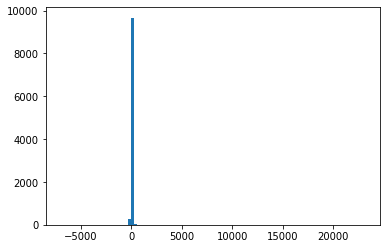

In [6]:
plt.hist((prior_predictive["beta"]).ravel(), bins=100)
plt.show()

## Inference

In [7]:
rng_key, rng_key_linear = random.split(rng_key)
numpyro.set_host_device_count(4)

kernel = infer.DiscreteHMCGibbs(infer.NUTS(spike_and_slab), modified=True)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(rng_key_linear, x, y)
posterior_samples = mcmc.get_samples()

mcmc.print_summary()

/Users/ryosukenagumo/bayesian_workflow/.venv/lib/python3.9/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 1500/1500 [00:02<00:00, 560.76it/s, 31 steps of size 7.40e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      bias    152.02      2.57    152.00    147.53    155.87   4483.30      1.00
     pi[0]      0.33      0.30      0.23      0.00      0.84   2160.15      1.00
     pi[1]      0.74      0.25      0.83      0.34      1.00   4872.73      1.00
     pi[2]      0.75      0.25      0.84      0.35      1.00   5103.59      1.00
     pi[3]      0.75      0.25      0.83      0.36      1.00   5297.89      1.00
     pi[4]      0.57      0.35      0.62      0.05      1.00    428.71      1.01
     pi[5]      0.45      0.35      0.41      0.00      0.97    674.75      1.01
     pi[6]      0.61      0.33      0.70      0.07      1.00    332.15      1.01
     pi[7]      0.47      0.35      0.44      0.00      0.97    524.87      1.00
     pi[8]      0.75      0.25      0.84      0.34      1.00   5328.09      1.00
     pi[9]      0.38      0.33      0.29      0.00      0.91   1335.88      1.00
         s    387.12    134

In [8]:
rng_key, rng_key_posterior = random.split(rng_key)
predictive = infer.Predictive(spike_and_slab, posterior_samples=posterior_samples)
posterior_predictive = predictive(rng_key_posterior, x)

# Plot

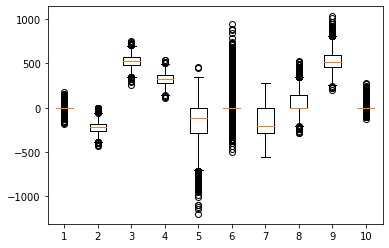

In [9]:
plt.boxplot(posterior_samples["beta"].T)
plt.show()

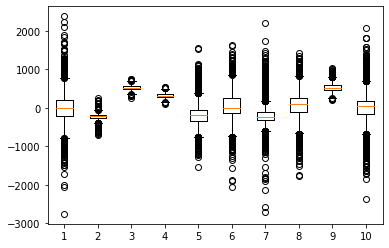

In [10]:
plt.boxplot(posterior_samples["w"].T)
plt.show()

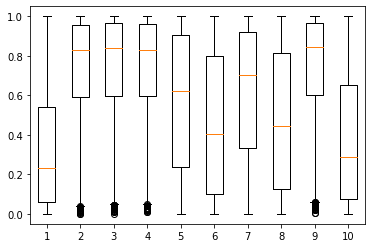

In [11]:
plt.boxplot(posterior_samples["pi"].T)
plt.show()

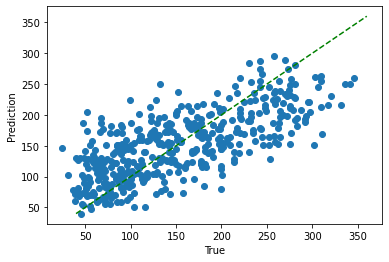

In [12]:
plt.scatter(y, posterior_predictive["y"].mean(0))
plt.plot([40, 360], [40, 360], "--g")
plt.xlabel("True")
plt.ylabel("Prediction")
plt.show()

# Arviz

In [13]:
numpyro_data = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)

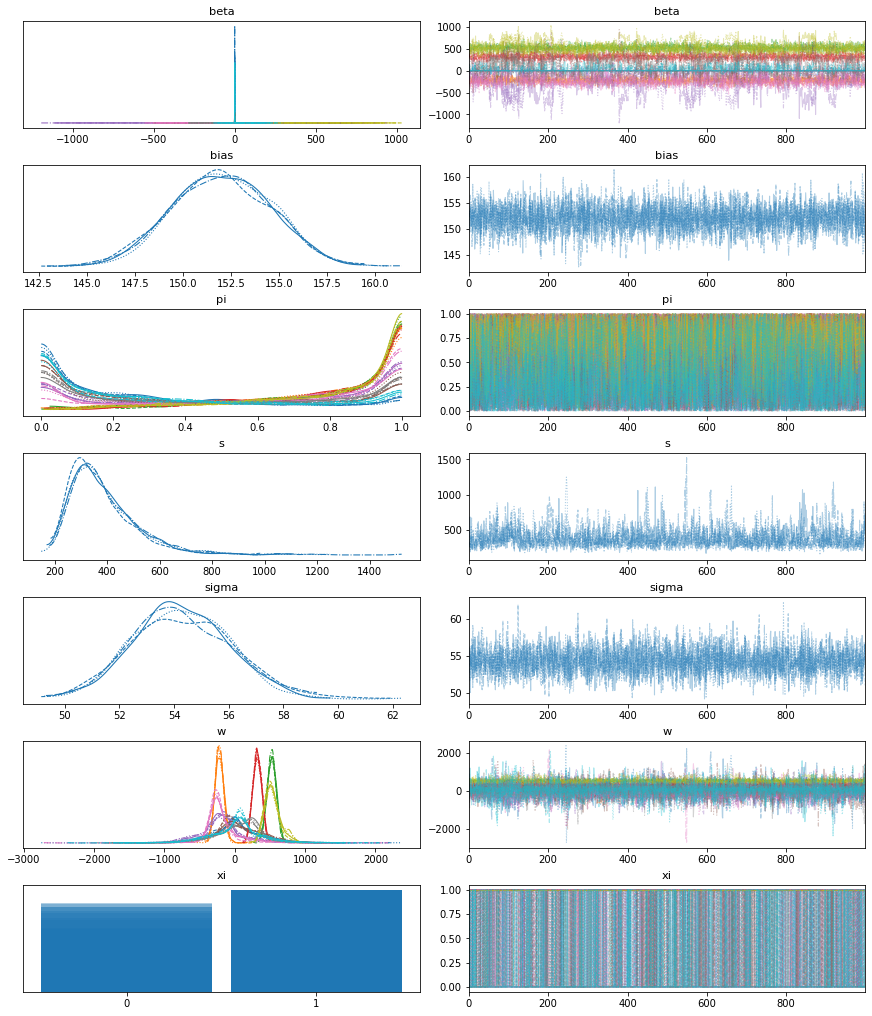

In [14]:
az.plot_trace(numpyro_data)
plt.show()

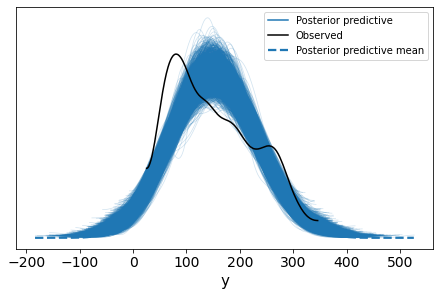

In [15]:
az.plot_ppc(numpyro_data)
plt.legend(loc="upper right")
plt.show()